In [3]:
import sys
import subprocess
import numpy as np
import xarray as xr
from scipy import stats
import Ngl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
from matplotlib.colors import Normalize
from numba import jit
from utilities import *
import importlib
%matplotlib inline
importlib.reload(plt)

label_size = 14
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 

H  = 7.0e3
a = 6.37e6
g  = 9.8
om = 7.292e-5  
R = 287.05
Cp = 1.0035e3

gw = xr.open_dataset('../pp_data/gw.nc',decode_times=False)['gw'].squeeze()

In [4]:
def calc_TEM_from_h0_file2(data):
#define constants
    H  = 7.0e3
    a = 6.37e6
    g  = 9.8
    om = 7.292e-5  
    R = 287.05
    Cp = 1.0035e3
    
    print('loading data...')

    #load data from dataset
    P0 = data.P0.values
    time=data.time
    ntime = time.shape[0]
    lat = data.lat
    nlat = lat.shape[0]
    nlon = 4
    phi = np.deg2rad(lat)
    lev = data.lev
    nlev = lev.shape[0]
    ilev = data.ilev
    nilev = ilev.shape[0]
    coslat = np.cos(phi)
    sinlat = np.sin(phi)
    zp = H*np.log(P0/(100*lev))
    zpi = H*np.log(P0/(100*ilev))
    rho = P0/(g*H) * np.exp(-zp/H)

    hyai = data.hyai
    hyam = data.hyam
    hybi = data.hybi
    hybm = data.hybm

    PS = data.PS
    U = data['U']
    U = U.where(U<1e10)
    V = data['V']
    V = V.where(V<1e10)
    OMG = data['OMEGA']
    OMG = OMG.where(OMG<1e10)
    W = (-H/(lev*100)*OMG).transpose('time','lev','lat')
    TH = data['TH']
    TH = TH.where(TH<1e10)
    VTH = data['VTHzm'].squeeze(dim='zlon')
    VTH = VTH.where(VTH<1e10)
    UV = data['UVzm'].squeeze(dim='zlon')
    UV = UV.where(UV<1e10)
    UW = data['UWzm'].squeeze(dim='zlon')
    UW = UW.where(UW<1e10)
    
    print('Finished loading data')
    print('Interpolating...')

    #create dummy DataArray object to hold interpolated variables
    dummy_arr = np.zeros(shape=[ntime,nlev,nlat])
    dummy_out = xr.DataArray(data=dummy_arr,dims=('time','lev','lat'),coords={'time':time,'lev':lev,'lat':lat})
    Up = dummy_out.copy(deep=True)
    Vp = dummy_out.copy(deep=True)
    Wp = dummy_out.copy(deep=True)
    THp = dummy_out.copy(deep=True)
    VTHp = dummy_out.copy(deep=True)
    UVp = dummy_out.copy(deep=True)
    UWp = dummy_out.copy(deep=True)

    Up[:] = Ngl.vinth2p(np.broadcast_to(U.values[...,None],U.shape+(nlon,)),hyam.values,hybm.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    Vp[:] = Ngl.vinth2p(np.broadcast_to(V.values[...,None],V.shape+(nlon,)),hyam.values,hybm.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    Wp[:] = Ngl.vinth2p(np.broadcast_to(W.values[...,None],W.shape+(nlon,)),hyam.values,hybm.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    THp[:] = Ngl.vinth2p(np.broadcast_to(TH.values[...,None],TH.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    VTHp[:] = Ngl.vinth2p(np.broadcast_to(VTH.values[...,None],VTH.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    UVp[:] = Ngl.vinth2p(np.broadcast_to(UV.values[...,None],UV.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    UWp[:] = Ngl.vinth2p(np.broadcast_to(UW.values[...,None],UW.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)

    print('Finished interpolating')
    print('Calculating TEM terms')
    
     #calculate d\bar\theta/dz
    thbar_z = dummy_out.copy(deep=True)
    thbar_z[:] = np.gradient(THp,zp,axis=-2,edge_order=2)

    thbar_z.values[(thbar_z<1e-4).values]=1e-4 #put floor on thbar_z. Do not know why but from NCAR script

    print('Calculating wbar*')
    #calculate wbar*
    derivand=(coslat*VTHp/thbar_z).transpose('time','lev','lat')
    derivative = dummy_out.copy(deep=True)
    derivative[:] = np.gradient(derivand,phi,axis=-1,edge_order=2)
    d2y = dummy_out.copy(deep=True)
    d2y[:] = np.gradient(derivative,phi,axis=-1)

    wstar = Wp+derivative/(a*coslat)
    wstar[:,:,0] = Wp[:,:,0]-(1./(a*sinlat[0]))*d2y[:,:,0]
    wstar[:,:,-1] = Wp[:,:,-1]-(1./(a*sinlat[-1]))*d2y[:,:,-1]
    
    print('Calculating vbar*')
    #calculate vbar*
    derivand = (rho*VTHp/thbar_z).transpose('time','lev','lat')
    derivative = dummy_out.copy(deep=True)
    derivative[:] = np.gradient(derivand,zp,axis=-2,edge_order=2)
    vstar = Vp-derivative
    
    print('Calculating EP-flux')
    #calculate EP-flux
    fc = 2.*om*sinlat
    ubar_z = dummy_out.copy(deep=True)
    ubar_z[:] = np.gradient(Up,zp,axis=-2,edge_order=2)
    ubar_y = dummy_out.copy(deep=True)
    ucoslat = (Up*coslat).transpose('time','lev','lat')
    ubar_y[:] = (np.gradient(ucoslat.values,phi.values,axis=-1))
    ubar_y = (ubar_y/(a*coslat)).transpose('time','lev','lat')
    fy = dummy_out.copy(deep=True)
    fz = dummy_out.copy(deep=True)
    fy[:] = ((ubar_z*VTHp/thbar_z-UVp)*rho*a*coslat).transpose('time','lev','lat')
    fy[...,0] = 0.0
    fy[...,-1] = 0.0
    fz[:] = ((fc-ubar_y*VTHp/thbar_z-UWp)*rho*a*coslat).transpose('time','lev','lat')
    fz[...,0] = 0.0
    fz[...,-1] = 0.0
    
    print('Calculating divergence of EP-flux')
    
    fycoslat = (coslat*fy).transpose('time','lev','lat')
    fyy = dummy_out.copy(deep=True)
    fyy[:] = np.gradient(fycoslat,phi,axis=-1)
    fyy = (1/(a*coslat)*fyy).transpose('time','lev','lat')
    fyy = (fyy/(a*rho*coslat)).transpose('time','lev','lat')
    
    fyy[...,0] = 0.0
    fyy[...,-1] = 0.0
    
    fzz = dummy_out.copy(deep=True)
    fzz[:] = np.gradient(fz,zp,axis=-2)
    fzz = (fzz/(a*rho*coslat)).transpose('time','lev','lat')
    
    fzz[...,0] = 0.0
    fzz[...,-1] = 0.0
    
    print('Finished')
    return wstar,vstar,fy,fz,fyy,fzz,Wp

In [5]:
def calc_TEM_from_h0_file(data):
#define constants
    H  = 7.0e3
    a = 6.37e6
    g  = 9.8
    om = 7.292e-5  
    R = 287.05
    Cp = 1.0035e3
    
    print('loading data...')

    #load data from dataset
    P0 = 100000
    time=data.time
    ntime = time.shape[0]
    lat = data.lat
    nlat = lat.shape[0]
    nlon = 4
    phi = np.deg2rad(lat)
    lev = data.lev
    nlev = lev.shape[0]
    ilev = data.ilev
    nilev = ilev.shape[0]
    coslat = np.cos(phi)
    sinlat = np.sin(phi)
    zp = H*np.log(P0/(100*lev))
    zpi = H*np.log(P0/(100*ilev))
    rho = P0/(g*H) * np.exp(-zp/H)

    hyai = data.hyai[0,:]
    hyam = data.hyam[0,:]
    hybi = data.hybi[0,:]
    hybm = data.hybm[0,:]

    PS = data.PS
    U = data['U']
    U = U.where(U<1e10)
    V = data['V']
    V = V.where(V<1e10)
    OMG = data['OMEGA']
    OMG = OMG.where(OMG<1e10)
    W = (-H/(lev*100)*OMG).transpose('time','lev','lat')
    TH = data['TH']
    TH = TH.where(TH<1e10)
    VTH = data['VTHzm'].squeeze(dim='zlon')
    VTH = VTH.where(VTH<1e10)
    UV = data['UVzm'].squeeze(dim='zlon')
    UV = UV.where(UV<1e10)
    UW = data['UWzm'].squeeze(dim='zlon')
    UW = UW.where(UW<1e10)
    
    print('Finished loading data')
    print('Interpolating...')

    #create dummy DataArray object to hold interpolated variables
    dummy_arr = np.zeros(shape=[ntime,nlev,nlat])
    dummy_out = xr.DataArray(data=dummy_arr,dims=('time','lev','lat'),coords={'time':time,'lev':lev,'lat':lat})
    Up = dummy_out.copy(deep=True)
    Vp = dummy_out.copy(deep=True)
    Wp = dummy_out.copy(deep=True)
    THp = dummy_out.copy(deep=True)
    VTHp = dummy_out.copy(deep=True)
    UVp = dummy_out.copy(deep=True)
    UWp = dummy_out.copy(deep=True)

    Up[:] = Ngl.vinth2p(np.broadcast_to(U.values[...,None],U.shape+(nlon,)),hyam.values,hybm.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    Vp[:] = Ngl.vinth2p(np.broadcast_to(V.values[...,None],V.shape+(nlon,)),hyam.values,hybm.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    Wp[:] = Ngl.vinth2p(np.broadcast_to(W.values[...,None],W.shape+(nlon,)),hyam.values,hybm.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    THp[:] = Ngl.vinth2p(np.broadcast_to(TH.values[...,None],TH.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    VTHp[:] = Ngl.vinth2p(np.broadcast_to(VTH.values[...,None],VTH.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    UVp[:] = Ngl.vinth2p(np.broadcast_to(UV.values[...,None],UV.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)
    UWp[:] = Ngl.vinth2p(np.broadcast_to(UW.values[...,None],UW.shape+(nlon,)),hyai.values,hybi.values,lev.values,np.broadcast_to(PS.values[...,None],PS.shape+(nlon,)),1,P0/100,1,True).mean(axis=-1)

#     return

    print('Finished interpolating')
    print('Calculating TEM terms')
    
     #calculate d\bar\theta/dz
    thbar_z = dummy_out.copy(deep=True)
    thbar_z[:] = np.gradient(THp,zp,axis=-2,edge_order=2)

    thbar_z.values[(thbar_z<1e-4).values]=1e-4 #put floor on thbar_z. Do not know why but from NCAR script

    print('Calculating wbar*')
    #calculate wbar*
    derivand=(coslat*VTHp/thbar_z).transpose('time','lev','lat')
    derivative = dummy_out.copy(deep=True)
    derivative[:] = np.gradient(derivand,phi,axis=-1,edge_order=2)
    d2y = dummy_out.copy(deep=True)
    d2y[:] = np.gradient(derivative,phi,axis=-1)

    wstar = Wp+derivative/(a*coslat)
    wstar[:,:,0] = Wp[:,:,0]-(1./(a*sinlat[0]))*d2y[:,:,0]
    wstar[:,:,-1] = Wp[:,:,-1]-(1./(a*sinlat[-1]))*d2y[:,:,-1]
    
    print('Calculating vbar*')
    #calculate vbar*
    derivand = (rho*VTHp/thbar_z).transpose('time','lev','lat')
    derivative = dummy_out.copy(deep=True)
    derivative[:] = np.gradient(derivand,zp,axis=-2,edge_order=2)
    vstar = Vp-derivative
    
    print('Calculating EP-flux')
    #calculate EP-flux
    fc = 2.*om*sinlat
    ubar_z = dummy_out.copy(deep=True)
    ubar_z[:] = np.gradient(Up,zp,axis=-2,edge_order=2)
    ubar_y = dummy_out.copy(deep=True)
    ucoslat = (Up*coslat).transpose('time','lev','lat')
    ubar_y[:] = (np.gradient(ucoslat.values,phi.values,axis=-1))
    ubar_y = (ubar_y/(a*coslat)).transpose('time','lev','lat')
    fy = dummy_out.copy(deep=True)
    fz = dummy_out.copy(deep=True)
    fy[:] = ((ubar_z*VTHp/thbar_z-UVp)*rho*a*coslat).transpose('time','lev','lat')
    fy[...,0] = 0.0
    fy[...,-1] = 0.0
    fz[:] = ((fc-ubar_y*VTHp/thbar_z-UWp)*rho*a*coslat).transpose('time','lev','lat')
    fz[...,0] = 0.0
    fz[...,-1] = 0.0
    
    print('Calculating divergence of EP-flux')
    
    fycoslat = (coslat*fy).transpose('time','lev','lat')
    fyy = dummy_out.copy(deep=True)
    fyy[:] = np.gradient(fycoslat,phi,axis=-1)
    fyy = (1/(a*coslat)*fyy).transpose('time','lev','lat')
    fyy = (fyy/(a*rho*coslat)).transpose('time','lev','lat')
    
    fyy[...,0] = 0.0
    fyy[...,-1] = 0.0
    
    fzz = dummy_out.copy(deep=True)
    fzz[:] = np.gradient(fz,zp,axis=-2)
    fzz = (fzz/(a*rho*coslat)).transpose('time','lev','lat')
    
    fzz[...,0] = 0.0
    fzz[...,-1] = 0.0
    
    print('Finished')
    return wstar,vstar,fy,fz,fyy,fzz

In [6]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self,
                 value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [7]:
def differtiate_DA_lat(DataArray):
    a = 6.37e6
    phi = np.deg2rad(DataArray.lat).values
    dDAdy = DataArray.copy(deep=True)
    dDAdy[:] = 0.0
    dDAdy[:] = (1/a)*np.gradient(DataArray,(phi[1]-phi[0]),axis=-1,edge_order=2)
    return dDAdy

In [8]:
colors=colordefs()
norm = MidpointNormalize(midpoint=0)
label_size = 12
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size 

# Get necessary data

In [10]:
ens_zonmean = xr.open_dataset('../pp_data/bwma1850.f09.ens.los_chocoyos.cam.h0.pre+ALLYEARS_rev000.zonmean.nc',decode_times=False).sel(time=slice(-1,38.99))

In [11]:
wstar_ens,vstar_ens,fy_ens,fz_ens,fyy_ens,fzz_ens = calc_TEM_from_h0_file(ens_zonmean[['U','V','OMEGA','TH','VTHzm','UVzm','UWzm','T','UTGWORO','UTGWSPEC','BUTGWSPEC','PS','P0','hyam','hybm','hyai','hybi']].mean(dim='record'))

loading data...
Finished loading data
Interpolating...
Finished interpolating
Calculating TEM terms
Calculating wbar*
Calculating vbar*
Calculating EP-flux
Calculating divergence of EP-flux
Finished


In [10]:
divF_ens = (fyy_ens+fzz_ens)*86400

In [11]:
gwd_ens = (ens_zonmean['UTGWORO']+ens_zonmean['UTGWSPEC']+ens_zonmean['BUTGWSPEC'])*86400

In [12]:
U_ens = ens_zonmean['U'].mean(dim='record')

In [13]:
#calculate -w* * du/dz
z = 7e3*np.log(ens_zonmean.P0.mean(dim=['record','time']).values/(100*ens_zonmean.lev))
dudz_ens = U_ens.copy(deep=True)
dudz_ens.shape
dudz_ens[:] = np.gradient(U_ens.values,z,axis=1,edge_order=2)
wdudz_ens = (-wstar_ens*dudz_ens)*86400

In [14]:
#calculate -v* * 1/(a*cos(phi))*d/dy(a*u*cos(phi))

phi = np.deg2rad(vstar_ens.lat.values)
dUdy_ens = 1/(a*np.cos(phi))*differtiate_DA_lat(a*U_ens*np.cos(phi))

vdUdy_ens = (-vstar_ens*dUdy_ens)*86400
# vdUdy_trop_ens = vdUdy_ens.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [15]:
varlist = ['U','V','T','O3','OMEGA','TH','VTHzm','UVzm','UWzm','T','UTGWORO','UTGWSPEC','BUTGWSPEC','SAD_AERO','PS','P0','hyam','hybm','hyai','hybi']

In [16]:
sulf_zonmean = xr.open_dataset('LCY_sulf_zonmean/bwma1850.f09.sulf.los_chocoyos.cam.h0.ALLYEARS_rev000.zonmean.nc',decode_times=False)


In [17]:
wstar_sulf,vstar_sulf,fy_sulf,fz_sulf,fyy_sulf,fzz_sulf,Wp_sulf = calc_TEM_from_h0_file2(sulf_zonmean[['U','V','OMEGA','TH','VTHzm','UVzm','UWzm','T','UTGWORO','UTGWSPEC','BUTGWSPEC','PS','P0','hyam','hybm','hyai','hybi']].mean(dim='record'))

loading data...
Finished loading data
Interpolating...
Finished interpolating
Calculating TEM terms
Calculating wbar*
Calculating vbar*
Calculating EP-flux
Calculating divergence of EP-flux
Finished


In [18]:
divF_sulf = (fyy_sulf+fzz_sulf)*86400

In [19]:
gwd_sulf = (sulf_zonmean['UTGWORO']+sulf_zonmean['UTGWSPEC']+sulf_zonmean['BUTGWSPEC'])*86400

In [20]:
U_sulf = sulf_zonmean['U'].mean(dim='record')

In [21]:
#calculate -w* * du/dz
# z = 7e3*np.log(ctrzon.P0.values/(100*ctrzon.lev))
dudz_sulf = U_sulf.copy(deep=True)
# dudz_.shape
dudz_sulf[:] = np.gradient(U_sulf.values,z,axis=-2,edge_order=2)
wdudz_sulf = (-wstar_sulf*dudz_sulf)*86400

In [22]:
#calculate -v* * 1/(a*cos(phi))*d/dy(a*u*cos(phi))

dUdy_sulf = 1/(a*np.cos(phi))*differtiate_DA_lat(a*U_sulf*np.cos(phi))

vdUdy_sulf = (-vstar_sulf*dUdy_sulf)*86400
# vdUdy_trop_ens = vdUdy_ens.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [23]:
climzon = xr.open_dataset('../bwma1850.f09.test1/atm/hist/clim/bwma1850.f09.test1.cam.h0.year.zonmean.nc',decode_times=False)


In [25]:
wstar_clim,vstar_clim,fy_clim,fz_clim,fyy_clim,fzz_clim,Wp_clim = calc_TEM_from_h0_file2(climzon[['U','V','OMEGA','TH','VTHzm','UVzm','UWzm','T','UTGWORO','UTGWSPEC','BUTGWSPEC','PS','P0','hyam','hybm','hyai','hybi']])

loading data...
Finished loading data
Interpolating...
Finished interpolating
Calculating TEM terms
Calculating wbar*
Calculating vbar*
Calculating EP-flux
Calculating divergence of EP-flux
Finished


In [26]:
divF_clim = (fyy_clim+fzz_clim)*86400

In [27]:
gwd_clim = (climzon['UTGWORO']+climzon['UTGWSPEC']+climzon['BUTGWSPEC'])*86400

In [28]:
U_clim = climzon['U']

In [29]:
#calculate -w* * du/dz
# z = 7e3*np.log(ctrzon.P0.values/(100*ctrzon.lev))
dudz_clim = U_clim.copy(deep=True)
dudz_clim[:] = np.gradient(U_clim.values,z,axis=-2,edge_order=2)
wdudz_clim = (-wstar_clim*dudz_clim)*86400

In [30]:
#calculate -v* * 1/(a*cos(phi))*d/dy(a*u*cos(phi))

dUdy_clim = 1/(a*np.cos(phi))*differtiate_DA_lat(a*U_clim*np.cos(phi))

vdUdy_clim = (-vstar_clim*dUdy_clim)*86400
# vdUdy_trop_ens = vdUdy_ens.sel(lat=slice(-2,2)).reduce(np.average,dim='lat',weights=gw.sel(lat=slice(-2,2)))

In [43]:
#latitude and level limits for plotting
latmax = 40
latmin = -40
levmin = 0.9
levmax = 200

In [44]:
SAD_factor = 1e8

In [95]:
# Time limits for making averages. To recreate figures run twice with limits 0-4.99 and then 5-8.99
tmin = 0 #5
tmax = 4.99 #8.99
ymin = tmin
ymax = int(np.floor(tmax-0.99))

8

In [96]:
U_ens = ens_zonmean['U'].sel(time=slice(tmin,tmax)).mean(dim='time').mean(dim='record')
T_ens = ens_zonmean['T'].sel(time=slice(tmin,tmax)).mean(dim='time').mean(dim='record')
O3_ens = ens_zonmean['O3'].sel(time=slice(tmin,tmax)).mean(dim='time').mean(dim='record')*1e6
SAD_ens = ens_zonmean['SAD_AERO'].sel(time=slice(tmin,tmax)).mean(dim='time').mean(dim='record')*SAD_factor

In [97]:
# make means over first 5 years for LCY_sulf
U_sulf = sulf_zonmean['U'].sel(time=slice(tmin,tmax)).mean(dim='time').mean(dim='record')
T_sulf = sulf_zonmean['T'].sel(time=slice(tmin,tmax)).mean(dim='time').mean(dim='record')
O3_sulf = sulf_zonmean['O3'].sel(time=slice(tmin,tmax)).mean(dim='time').mean(dim='record')*1e6
SAD_sulf = sulf_zonmean['SAD_AERO'].sel(time=slice(tmin,tmax)).mean(dim='time').mean(dim='record')*SAD_factor

In [98]:
# make means over first 5 years for LCY_full ensemble
U_clim = climzon['U'].mean(dim='time')
T_clim = climzon['T'].mean(dim='time')
O3_clim = climzon['O3'].mean(dim='time')*1e6
SAD_clim = climzon['SAD_AERO'].mean(dim='time')*SAD_factor
wstar_clim_m = wstar_clim.mean(dim='time')
vstar_clim_m = vstar_clim.mean(dim='time')
divF_clim_m = divF_clim.mean(dim='time')
gwd_clim_m = gwd_clim.mean(dim='time')

/home/hansb/miniconda3/envs/pya/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [99]:
#make anomalies
U_ens_anom = (U_ens-U_clim).squeeze()
T_ens_anom = (T_ens-T_clim).squeeze()
O3_ens_anom = (O3_ens-O3_clim).squeeze()
SAD_ens_anom = (SAD_ens-SAD_clim).squeeze()
wstar_ens_anom = (wstar_ens.sel(time=slice(tmin,tmax)).mean(dim='time')-wstar_clim.mean(dim='time')).squeeze()
vstar_ens_anom = (vstar_ens.sel(time=slice(tmin,tmax)).mean(dim='time')-vstar_clim.mean(dim='time')).squeeze()
divF_ens_anom = (divF_ens.sel(time=slice(tmin,tmax)).mean(dim='time')-divF_clim_m).squeeze()
gwd_ens_anom = (gwd_ens.sel(time=slice(tmin,tmax)).mean(dim='time').mean(dim='record')-gwd_clim_m).squeeze()
wdudz_ens_anom = (wdudz_ens-wdudz_clim).squeeze()

In [100]:
U_sulf_anom = (U_sulf-U_clim).squeeze()
T_sulf_anom = (T_sulf-T_clim).squeeze()
O3_sulf_anom = (O3_sulf-O3_clim).squeeze()
SAD_sulf_anom = (SAD_sulf-SAD_clim).squeeze()
wstar_sulf_anom = (wstar_sulf.sel(time=slice(tmin,tmax)).mean(dim='time')-wstar_clim.mean(dim='time')).squeeze()
vstar_sulf_anom = (vstar_sulf.sel(time=slice(tmin,tmax)).mean(dim='time')-vstar_clim.mean(dim='time')).squeeze()
divF_sulf_anom = (divF_sulf.sel(time=slice(tmin,tmax)).mean(dim='time')-divF_clim_m).squeeze()
gwd_sulf_anom = (gwd_sulf.sel(time=slice(tmin,tmax)).mean(dim='time').mean(dim='record')-gwd_clim_m).squeeze()
wdudz_sulf_anom = (wdudz_sulf-wdudz_clim).squeeze()

In [101]:
#define contour levels for plotting
Ulevs = np.arange(-24,24.1,4)
Ucslevs = np.arange(-60,60.1,10)
Tlevs = np.arange(-40,40,8)
Tcslevs = 8
O3levs = np.arange(-7,7.1,1)
wslevs = np.linspace(-1,1,11)
wscslevs = [-3,-1.4,-0.7,-0.3,-0.1,0,0.1,0.3,0.7,1.4,3]
vslevs = np.linspace(-0.4,0.4,11)
vscslevs = np.linspace(-0.4,0.4,9)

SADlevs = np.linspace(-300,300,21)

# gwdlevs = np.array([-0.2,-0.16667,-0.1333,-0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,
#         0.08,  0.1,0.1333,0.16667 ,0.2])
gwdlevs = np.linspace(-0.2,0.2,17)

divFlevs = np.linspace(-0.5,0.5,21)
divFcslevs = np.linspace(-0.6,0.6,7)

cs_color = 'gray'



In [103]:
def plot_lat_lev(CFdata,CSdata,CFlevs=10,CSlevs=10,clblabel='dummy',latmin=latmin,latmax=latmax,levmin=levmin,levmax=levmax,norm=None,extend='both'):
    #plt.figure(figsize=(5,3))
    CF = CFdata.sel(lev=slice(levmin,levmax)).plot.contourf(cmap='RdBu_r',extend=extend,levels=CFlevs,add_colorbar=False,norm=norm)
    clb = plt.colorbar(CF,pad=0.01)
    clb.set_label(clblabel,fontsize=16)
    CS = CSdata.sel(lev=slice(levmin,levmax)).plot.contour(colors='k',levels=CSlevs)
    plt.clabel(CS,inline=False,fmt='%1.1f',inline_spacing=0,colors='k',fontsize=12)
    for line, lvl in zip(CS.collections, CS.levels):
        line.set_color(cs_color)
        if lvl < 0:
            line.set_linestyle('--')

    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.xlim([latmin,latmax])
    plt.xlabel('Latitude',fontsize=16)
    plt.ylabel('Pressure levels [hPa]',fontsize=16)

In [104]:
norm = MidpointNormalize(midpoint=0)

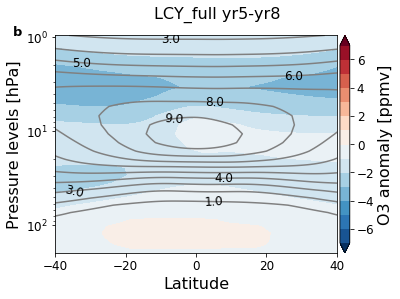

In [112]:
if tmin == 0:
    lab = 'a'
elif tmin ==5:
    lab = 'b'
else:
    raise ValueError('Wrong start time')

plot_lat_lev(O3_ens_anom,O3_clim,CFlevs=O3levs,CSlevs=11,clblabel='O3 anomaly [ppmv]')
plt.suptitle(f'LCY_full yr{ymin}-yr{int(ymax)}',fontsize=16)
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_O3_full = 'LCY_full_y{}-y{}_le{}_le{}_la{}-la{}_O3_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_O3_full,dpi=300,bbox_inches='tight')

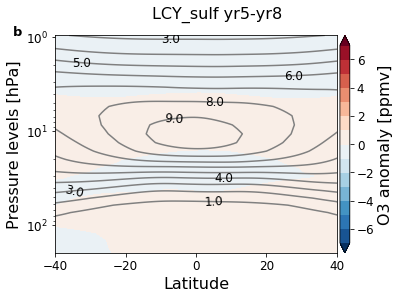

In [113]:
plot_lat_lev(O3_sulf_anom,O3_clim,CFlevs=O3levs,CSlevs=11,clblabel='O3 anomaly [ppmv]')
plt.suptitle(f'LCY_sulf yr{ymin}-yr{int(ymax)}',fontsize=16)
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_O3_sulf = 'LCY_sulf_y{}-y{}_le{}_le{}_la{}-la{}_O3_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_O3_sulf,dpi=300,bbox_inches='tight')

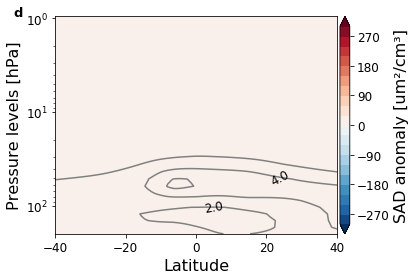

In [114]:
if tmin == 0:
    lab = 'c'
elif tmin ==5:
    lab = 'd'
else:
    raise ValueError('Wrong start time')

plot_lat_lev(SAD_ens_anom,SAD_clim,CFlevs=SADlevs,CSlevs=5,clblabel='SAD anomaly [um²/cm³]',levmax=levmax,norm=None)
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_SAD_full = 'LCY_full_y{}-y{}_le{}_le{}_la{}-la{}_SAD_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_SAD_full,dpi=300,bbox_inches='tight')

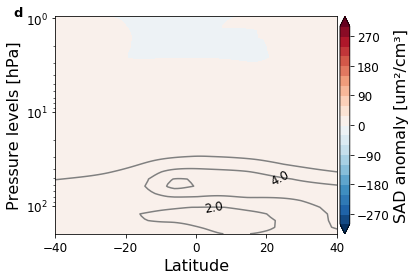

In [115]:
norm = MidpointNormalize(midpoint=0)
plot_lat_lev(SAD_sulf_anom,SAD_clim,CFlevs=SADlevs,CSlevs=5,clblabel='SAD anomaly [um²/cm³]',levmax=levmax,norm=None)
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_SAD_sulf = 'LCY_sulf_y{}-y{}_le{}_le{}_la{}-la{}_SAD_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_SAD_sulf,dpi=300,bbox_inches='tight')

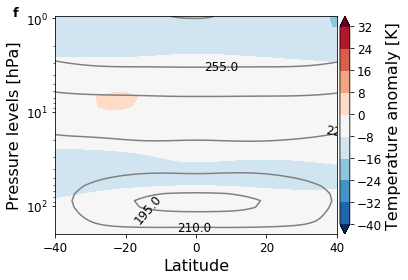

In [116]:
if tmin == 0:
    lab = 'e'
elif tmin ==5:
    lab = 'f'
else:
    raise ValueError('Wrong start time')

plot_lat_lev(T_ens_anom,T_clim,CFlevs=Tlevs,CSlevs=Tcslevs,clblabel='Temperature anomaly [K]')
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_T_full = 'LCY_full_y{}-y{}_le{}_le{}_la{}-la{}_T_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_T_full,dpi=300,bbox_inches='tight')

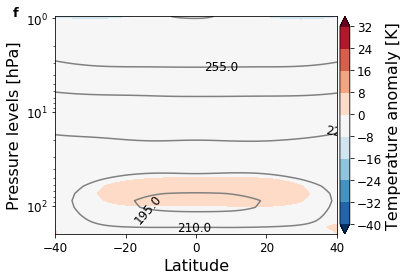

In [117]:
plot_lat_lev(T_sulf_anom,T_clim,CFlevs=Tlevs,CSlevs=Tcslevs,clblabel='Temperature anomaly [K]')
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_T_sulf = 'LCY_sulf_y{}-y{}_le{}_le{}_la{}-la{}_T_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_T_sulf,dpi=300,bbox_inches='tight')

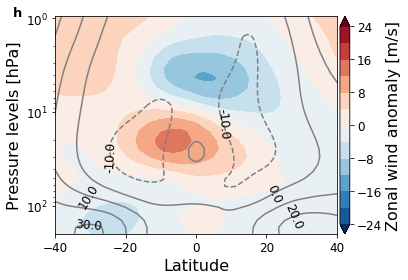

In [118]:
if tmin == 0:
    lab = 'g'
elif tmin ==5:
    lab = 'h'
else:
    raise ValueError('Wrong start time')

plot_lat_lev(U_ens_anom,U_clim,CFlevs=Ulevs,CSlevs=Ucslevs,clblabel='Zonal wind anomaly [m/s]')
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_U_full = 'LCY_full_y{}-y{}_le{}_le{}_la{}-la{}_U_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_U_full,dpi=300,bbox_inches='tight')

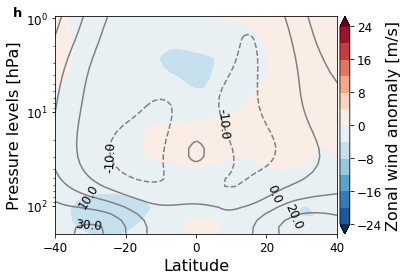

In [119]:
plot_lat_lev(U_sulf_anom,U_clim,CFlevs=Ulevs,CSlevs=Ucslevs,clblabel='Zonal wind anomaly [m/s]')
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_U_sulf = 'LCY_sulf_y{}-y{}_le{}_le{}_la{}-la{}_U_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_U_sulf,dpi=300,bbox_inches='tight')

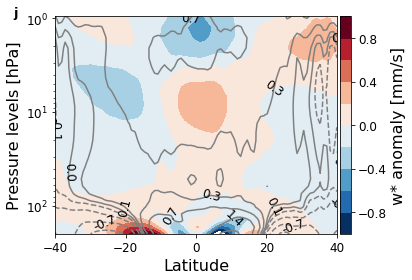

In [120]:
if tmin == 0:
    lab = 'i'
elif tmin ==5:
    lab = 'j'
else:
    raise ValueError('Wrong start time')

plot_lat_lev(1000*wstar_ens_anom,1000*wstar_clim_m,CFlevs=wslevs,CSlevs=wscslevs,clblabel='w* anomaly [mm/s]',levmax=levmax,extend='neither')
# plt.suptitle(f'LCY_full yr{ymin}-yr{int(ymax)}',fontsize=14)
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_ws_full = 'LCY_full_y{}-y{}_le{}_le{}_la{}-la{}_ws_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_ws_full,dpi=300,bbox_inches='tight')

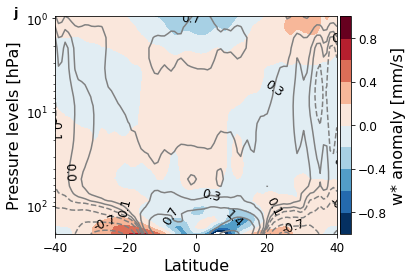

In [121]:
plot_lat_lev(1000*wstar_sulf_anom,1000*wstar_clim_m,CFlevs=wslevs,CSlevs=wscslevs,clblabel='w* anomaly [mm/s]',levmax=levmax,extend='neither')
# plt.suptitle(f'LCY_sulf yr{ymin}-yr{int(ymax)}',fontsize=14)
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_ws_sulf = 'LCY_sulf_y{}-y{}_le{}_le{}_la{}-la{}_ws_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_ws_sulf,dpi=300,bbox_inches='tight')

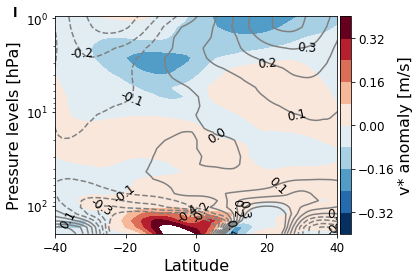

In [122]:
if tmin == 0:
    lab = 'k'
elif tmin ==5:
    lab = 'l'
else:
    raise ValueError('Wrong start time')

plot_lat_lev(vstar_ens_anom,vstar_clim_m,CFlevs=vslevs,CSlevs=vscslevs,clblabel='v* anomaly [m/s]',extend='neither')
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_vs_full = 'LCY_full_y{}-y{}_le{}_le{}_la{}-la{}_vs_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_vs_full,dpi=300,bbox_inches='tight')

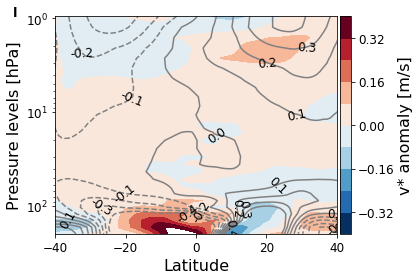

In [123]:
plot_lat_lev(vstar_sulf_anom,vstar_clim_m,CFlevs=vslevs,CSlevs=vscslevs,clblabel='v* anomaly [m/s]',extend='neither')
plt.gca().text(-0.15,1.0,lab,transform=plt.gca().transAxes,fontsize=13,weight='bold',fontname='arial')
savstr_vs_sulf = 'LCY_sulf_y{}-y{}_le{}_le{}_la{}-la{}_vs_anom_LatLev.png'.format(tmin,tmax,levmin,levmax,latmin,latmax)
plt.savefig(savstr_vs_sulf,dpi=300,bbox_inches='tight')

In [124]:
outstring1 = f'LCY_full_lat_lev_O3_SAD_T_U_ws_vs_y{tmin}-y{tmax}_le{levmin}-le{levmax}_la{latmin}-{latmax}.png'

In [125]:
# montage figures
# outstring = 'LCY_lat_lev_y{}-y{}_l{}-l{}.png'.format(tmin,tmax,latmin,latmax)
command = f"gm montage -geometry +2+2 -tile 1x6 {savstr_O3_full} {savstr_SAD_full} {savstr_T_full} {savstr_U_full} {savstr_ws_full} {savstr_vs_full} {outstring1}"

In [126]:
subprocess.Popen(command.split())

In [127]:
outstring1 = f'LCY_sulf_lat_lev_O3_SAD_T_U_ws_vs_y{tmin}-y{tmax}_le{levmin}-le{levmax}_la{latmin}-{latmax}.png'

In [128]:
# montage figures
# outstring = 'LCY_lat_lev_y{}-y{}_l{}-l{}.png'.format(tmin,tmax,latmin,latmax)
command = f"gm montage -geometry +2+2 -tile 1x6 {savstr_O3_sulf} {savstr_SAD_sulf} {savstr_T_sulf} {savstr_U_sulf} {savstr_ws_sulf} {savstr_vs_sulf} {outstring1}"

In [129]:
subprocess.Popen(command.split())

In [130]:
outstring2 = f'LCY_lat_lev_ws_vs_divF_gwd_y{tmin}-y{tmax}_le{levmin}-le{levmax}_la{latmin}-{latmax}.png'

In [131]:
# montage figures
# outstring = 'LCY_lat_lev_y{}-y{}_l{}-l{}.png'.format(tmin,tmax,latmin,latmax)
command = f"gm montage -geometry +2+2 -tile 2x4 {savstr_ws_full} {savstr_ws_sulf} {savstr_vs_full} {savstr_vs_sulf} {savstr_divF_full} {savstr_divF_sulf} {savstr_gwd_full} {savstr_gwd_sulf} {outstring2}"

In [132]:
subprocess.Popen(command.split())